In [1]:
%matplotlib inline

import os
# running with non gpu singularity container, so commented out the next line to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
tf.set_random_seed(42)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
           
import keras.backend.tensorflow_backend as K

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout
from keras.layers import LeakyReLU, Lambda
from keras.layers import Input, merge, Concatenate, concatenate, Add, Activation
from keras.losses import binary_crossentropy
from keras.datasets import mnist

import pandas as pd

import numpy as np
import time
import pickle
import sys

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.model_selection import train_test_split

from IPython.display import Image, display

np.random.seed(42)

/Library/Python/2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/Library/Python/2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Library/Python/2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/Library/Python/2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/Library/Python/2.7/site-packages/requests/__init_

In [2]:
def make_mnist_plots(preds,rows=None,cols=None,fname=None,show=False):
    n_examples = preds.shape[0]
    imgs = preds.reshape(n_examples, 28, 28)
    rows = rows or int(n_examples**0.5)
    cols = cols or int(n_examples**0.5)
    fig, axs = plt.subplots(rows,cols,figsize=(cols,rows))
    for img,ax in zip(imgs,axs.reshape(-1)):
        ax.imshow(img,cmap="gray_r")
        
    def clean(ax):
        ax.set_frame_on(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    map(clean,fig.axes)
    # fig.set_tight_layout(True)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.05)
    if fname: fig.savefig(fname)
    if show: display(Image(fname))



In [3]:
class GAN():
    def __init__(self, **kwargs):

        self.args = dict(kwargs)

        self.tag = kwargs["tag"]
        self.noise_shape = (int(kwargs["noise_size"]),)
        self.output_shape = (int(kwargs["output_size"]),)
        self.nepochs_dump_pred_metrics = int(kwargs["nepochs_dump_pred_metrics"])
        self.nepochs_dump_plots = int(kwargs["nepochs_dump_plots"])
        self.nepochs_max = int(kwargs["nepochs_max"])
        self.batch_size = int(kwargs["batch_size"])
        self.do_soft_labels = kwargs["do_soft_labels"]
        self.do_noisy_labels = kwargs["do_noisy_labels"]
        self.nepochs_decay_noisy_labels = int(kwargs["nepochs_decay_noisy_labels"])
        self.terminate_early = kwargs["terminate_early"]
        self.mnist_noise = kwargs.get("mnist_noise",100)
        
        
        os.system("mkdir -p ./progress/{}/".format(self.tag))

        self.data = None
        self.d_epochinfo = {}
        self.X_train = None

        self.noise_shape = (self.mnist_noise,)
        self.output_shape = (784,)
        self.optimizer_disc = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        self.optimizer_gen = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        
        optimizer_d = self.optimizer_disc
        optimizer_g = self.optimizer_gen
        
        self.loss = "binary_crossentropy"
            
        # Build and compile the two independent models
        self.generator = self.build_generator()
        self.generator.compile(loss=self.loss, optimizer=optimizer_g)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.loss, optimizer=optimizer_d, metrics=['accuracy'])
        
        # Make the combined model
        # The combined model (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.discriminator.trainable = False #only train the generator
        z = Input(shape=self.noise_shape)
        img = self.generator(z)
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.loss, optimizer=optimizer_g)


In [4]:
class GAN(GAN):
    
    def build_generator(self):
    
        inputs = Input(shape=self.noise_shape)
        for iw,w in enumerate([600,400,300]):
            extra = {}
            if iw == 0:
                extra = {"kernel_initializer":keras.initializers.RandomNormal(stddev=0.02)}
            x = Dense(w, **extra)(inputs if iw == 0 else x)
            x = LeakyReLU(0.2)(x)
        
        x = Dense(self.output_shape[0], activation="tanh")(x)
        model = Model(inputs=inputs, outputs=x)

        print "Generator params: {}".format(model.count_params())
        
        return model
    
    def build_discriminator(self):

        discriminator = Sequential()
        
        inputs = Input(shape=self.output_shape)
        for iw,w in enumerate([400,200,100]):
            extra = {}
            if iw == 0:
                extra = {"kernel_initializer":keras.initializers.RandomNormal(stddev=0.02)}
            x = Dense(w, **extra)(inputs if iw == 0 else x)
            x = LeakyReLU(0.2)(x)
            x = Dropout(0.3)(x)
        
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inputs, outputs=x)
        
        print "Discriminator params: {}".format(model.count_params())
        
        return model

In [5]:
class GAN(GAN):
    
    def load_data(self):
        if self.data is not None: return
        
        (self.data, y_train), (X_test, y_test) = mnist.load_data()
        self.data = np.array([x.flatten() for x in self.data[:]])

    def get_noise(self, amount=1024):
        noise_half = np.random.normal(0, 1, (amount//2, self.noise_shape[0]))
        noise_full = np.random.normal(0, 1, (amount, self.noise_shape[0]))
        return noise_half, noise_full

            
    def train(self):

        self.load_data()
        
        self.losses = []
        
        self.X_train = (self.data.astype(np.float32) - 127.5)/127.5


        # make an alias to save typing
        X_train = self.X_train
        
        half_batch = int(self.batch_size / 2)

        prev_gen_loss = -1
        prev_disc_loss = -1
        n_loss_same_gen = 0  # number of epochs for which generator loss has remained ~same (within 0.01%)
        n_loss_same_disc = 0  # number of epochs for which discriminator loss has remained ~same (within 0.01%)
        old_info = -1, -1
        
        pbar = tqdm(range(self.nepochs_max))
        
        for epoch in pbar:

            if self.terminate_early:
                if n_loss_same_gen > 1000 or n_loss_same_disc > 1000:
                    print "BREAKING because disc/gen loss has remained the same for {}/{} epochs!".format(n_loss_same_disc,n_loss_same_gen)
                    break

            self.discriminator.trainable = True
            
            ndisc = 1
            for idisc in range(ndisc):
                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise_half, noise_full = self.get_noise(self.batch_size)
                gen_imgs = self.generator.predict(noise_full)

                ones = np.ones((half_batch, 1))
                zeros = np.zeros((half_batch, 1))
                if self.do_soft_labels: ones *= 0.9
                if self.do_noisy_labels:
                    frac = 0.3*np.exp(-epoch/self.nepochs_decay_noisy_labels)
                    if frac > 0.005:
                        ones[np.random.randint(0, len(ones), int(frac*len(ones)))] = 0
                        zeros[np.random.randint(0, len(zeros), int(frac*len(zeros)))] = 1

                d_loss = self.discriminator.train_on_batch(np.concatenate([imgs, gen_imgs[:half_batch]]), np.concatenate([ones, zeros]))

            self.discriminator.trainable = False
            
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * self.batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise_full, valid_y)

            if (g_loss - prev_gen_loss) < 0.0001: n_loss_same_gen += 1
            else: n_loss_same_gen = 0
            prev_gen_loss = g_loss

            if (d_loss[0] - prev_disc_loss) < 0.0001: n_loss_same_disc += 1
            else: n_loss_same_disc = 0
            prev_disc_loss = d_loss[0]
            
            if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
                if "epoch" not in self.d_epochinfo:
                    self.d_epochinfo["epoch"] = []
                    self.d_epochinfo["d_acc"] = []
                    self.d_epochinfo["d_loss"] = []
                    self.d_epochinfo["g_loss"] = []
                else:
                    self.d_epochinfo["epoch"].append(epoch)
                    self.d_epochinfo["d_acc"].append(100*d_loss[1])
                    self.d_epochinfo["d_loss"].append(d_loss[0])
                    self.d_epochinfo["g_loss"].append(g_loss)

#             sys.stdout.write("\r{} [D loss: {}, acc.: {:.2f}%] [G loss: {}]".format(epoch, d_loss[0], 100.0*d_loss[1], g_loss))
            if epoch % 5 == 0:
                pbar.set_description("{} [D loss: {:.2f}, acc.: {:.1f}%] [G loss: {:.2f}]".format(epoch, d_loss[0], 100.0*d_loss[1], g_loss))
            if epoch % self.nepochs_dump_plots == 0 and epoch > 0:
                fname = "./progress/{}/gan_generated_image_epoch_{}.png".format(self.tag, epoch)
                make_mnist_plots(gen_imgs[:36], fname=fname,show=True)
            


In [6]:
# defaults
params = {
        "output_size": 784,
        "noise_size": 100,
        "nepochs_dump_pred_metrics": 50,
        "nepochs_dump_plots": 3000,
        "nepochs_max": 25001,
        "batch_size": 256,
        "do_soft_labels": False,
        "do_noisy_labels": False,
        "terminate_early": True,
        "nepochs_decay_noisy_labels": 2000,
        }

# change tag for provenance
params["tag"] = "mnist_v5_default"

# print params
gan = GAN(**params)


Generator params: 657284
Discriminator params: 414401


3000 [D loss: 0.28, acc.: 87.5%] [G loss: 2.91]:  12%|█▏        | 3000/25001 [02:50<19:37, 18.68it/s]

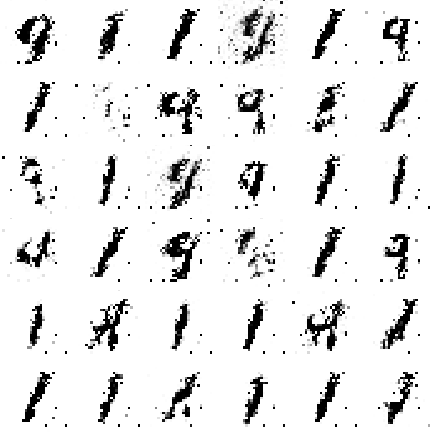

6000 [D loss: 0.46, acc.: 80.5%] [G loss: 1.37]:  24%|██▍       | 6000/25001 [05:36<18:26, 17.18it/s]

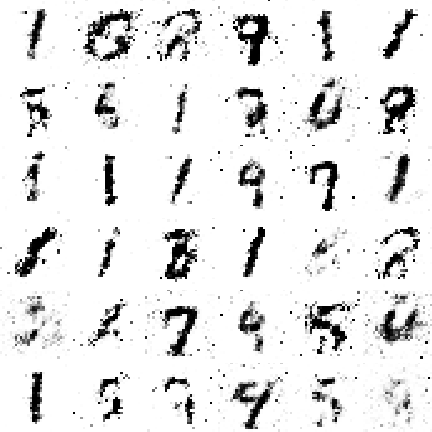

9000 [D loss: 0.55, acc.: 71.9%] [G loss: 1.08]:  36%|███▌      | 9000/25001 [08:32<15:23, 17.33it/s]

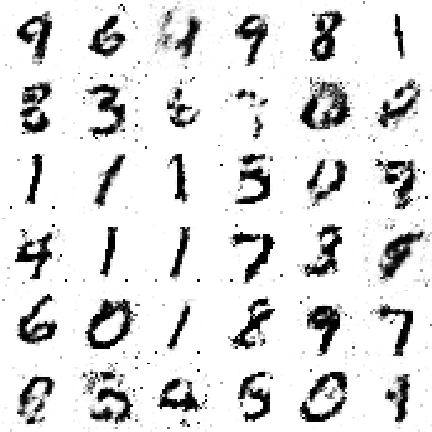

12000 [D loss: 0.54, acc.: 72.3%] [G loss: 1.10]:  48%|████▊     | 12000/25001 [11:26<12:22, 17.52it/s]

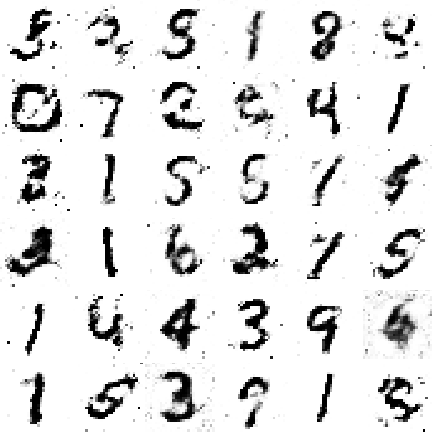

15000 [D loss: 0.59, acc.: 66.8%] [G loss: 0.98]:  60%|█████▉    | 15000/25001 [14:22<09:36, 17.35it/s]

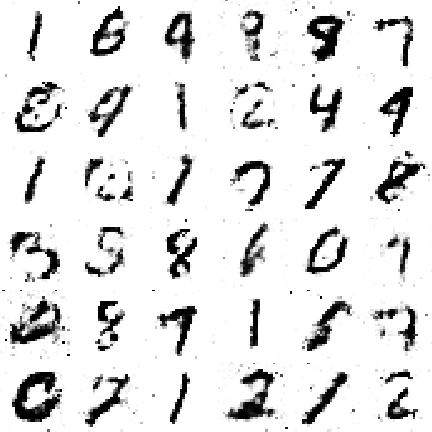

18000 [D loss: 0.65, acc.: 61.3%] [G loss: 0.98]:  72%|███████▏  | 18000/25001 [17:17<06:44, 17.30it/s]

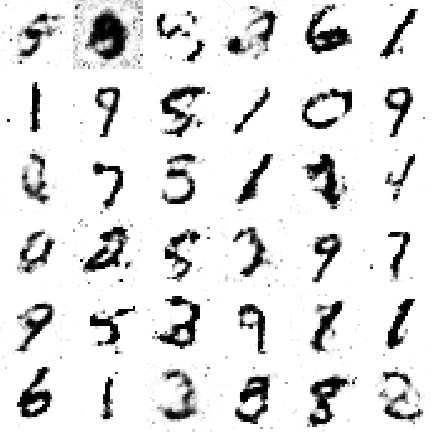

21000 [D loss: 0.63, acc.: 65.2%] [G loss: 0.85]:  84%|████████▍ | 21000/25001 [20:12<03:48, 17.50it/s]

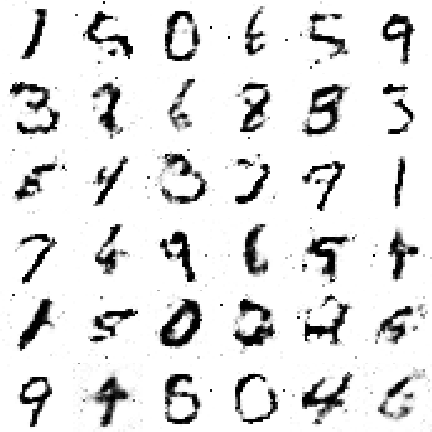

24000 [D loss: 0.63, acc.: 62.5%] [G loss: 0.93]:  96%|█████████▌| 24000/25001 [23:07<00:57, 17.55it/s]

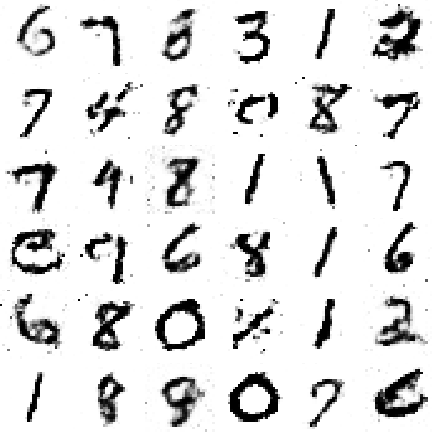

25000 [D loss: 0.62, acc.: 64.8%] [G loss: 1.03]: 100%|██████████| 25001/25001 [24:01<00:00, 17.35it/s]


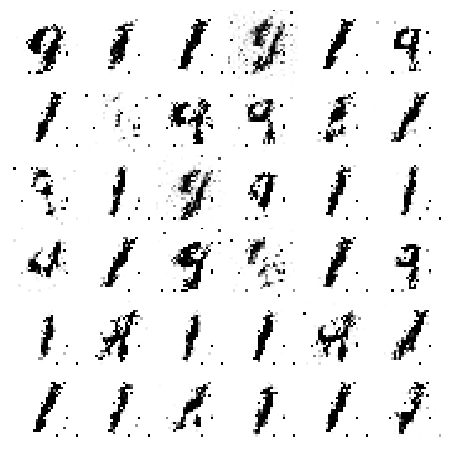

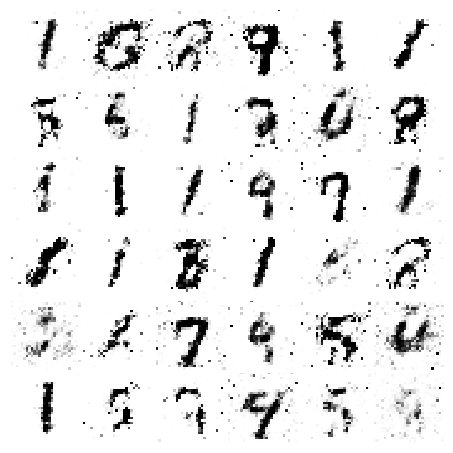

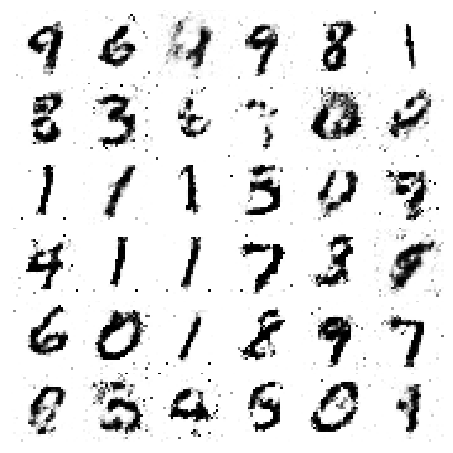

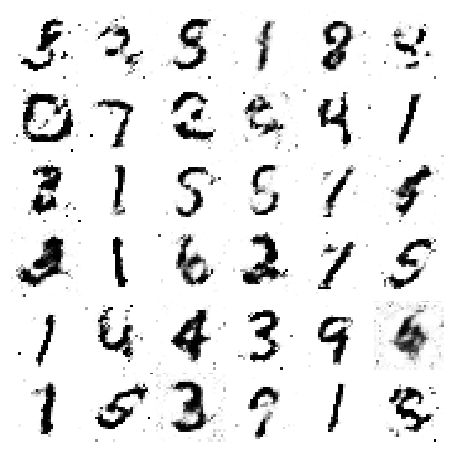

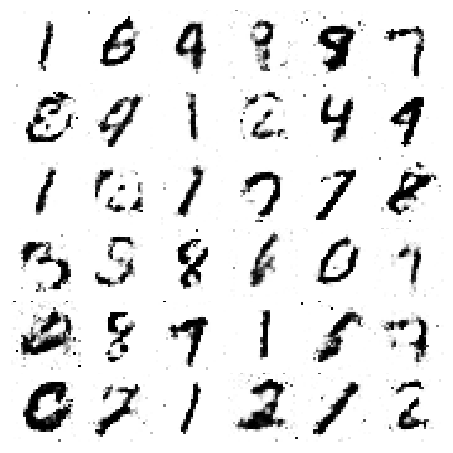

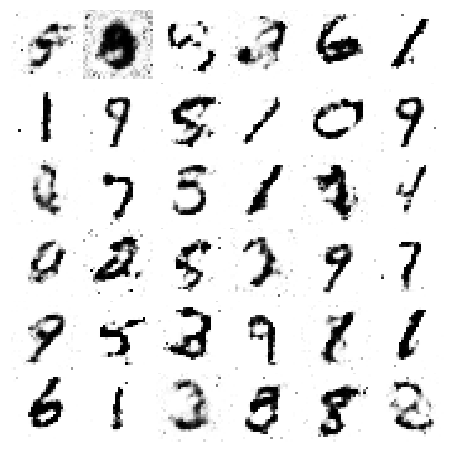

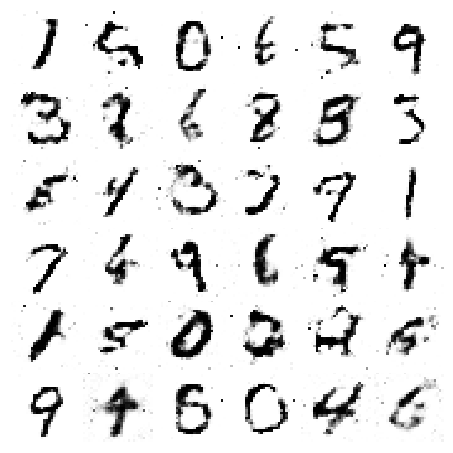

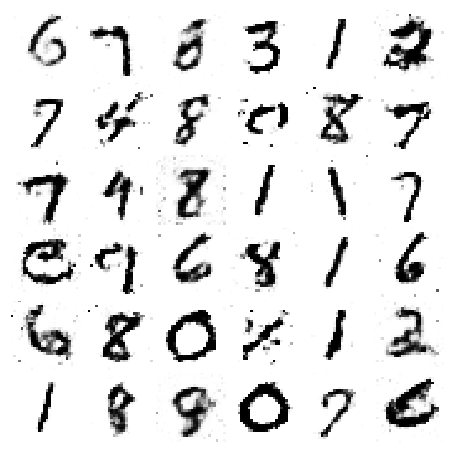

In [7]:
gan.train()

In [8]:
df = pd.DataFrame(gan.d_epochinfo)

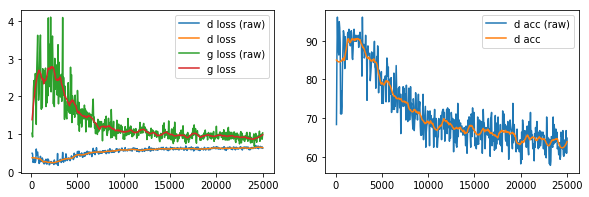

In [9]:
def smooth(x,window=31,npoly=2):
    from scipy.signal import savgol_filter
    return savgol_filter(x,window,npoly)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3))
ax1.plot(df.epoch,df["d_loss"],label="d loss (raw)")
ax1.plot(df.epoch,smooth(df["d_loss"]),label="d loss")
ax1.plot(df.epoch,df["g_loss"],label="g loss (raw)")
ax1.plot(df.epoch,smooth(df["g_loss"]),label="g loss")
# ax1.set_yscale("log",nonposy="clip")
ax1.legend()
ax2.plot(df["epoch"],df["d_acc"], label="d acc (raw)")
ax2.plot(df["epoch"],smooth(df["d_acc"]), label="d acc")
ax2.legend()

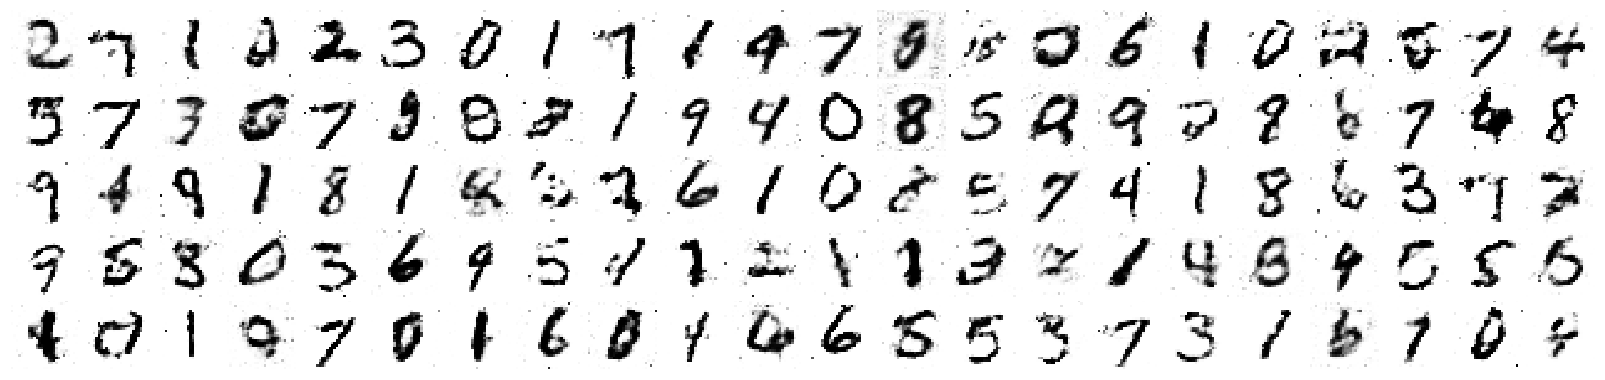

In [10]:
make_mnist_plots(gan.generator.predict(gan.get_noise(110)[1]),rows=5,cols=22)